<a href="https://colab.research.google.com/github/illia-nest/automatic-public-discourse-analysis/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN with multiple inputs for NLP

In [13]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Activation, GlobalMaxPooling1D, Concatenate, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [15]:
cols = ['text', 'pos', 'manifesto_id', 'party', 'cmp_code']

data_raw = (pd.read_csv(r'/content/drive/MyDrive/AutoPDA/data_manifesto_corpus_2017-2_english.csv', low_memory=False)
    .filter(items=cols)
    .assign(domain=lambda df: df.cmp_code.astype(str).str.split('').str[1])
    .reindex(columns=[*cols, 'domain'])
    .rename(columns={
        'text' : 'phrase',
        'cmp_code' : 'subdomain'
    }))

In [16]:
# Tokenize and pad the phrases, reshape data
phases_for_tokenization = data_raw['phrase'].astype(str)
max_sequence_length = 60
tokenizer = Tokenizer(num_words=None, oov_token="<OOV>")
tokenizer.fit_on_texts(phases_for_tokenization)
sequences = tokenizer.texts_to_sequences(phases_for_tokenization)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [17]:
data = (data_raw.assign(
                    phrase = list(padded_sequences),
                    prev_phrase=lambda df: df.groupby('manifesto_id')['phrase'].shift(1))
                .reindex(columns=['prev_phrase', *list(data_raw.columns)])
                .loc[lambda df: df['subdomain'].str.len() == 3]
                .loc[lambda df: df['subdomain'] != '000']
                .query("pos != 1")).reset_index(drop=True)

In [18]:
# One-hot encoding parties, finishing data transformation.
encoder = OneHotEncoder(sparse_output=False)
party_one_hot = encoder.fit_transform(data.party.values.reshape(-1, 1))

one_hot_series = pd.Series([one_hot.tolist() for one_hot in party_one_hot])

In [19]:
# Add the new Series as a column to the existing DataFrame
data['party_one_hot'] = one_hot_series
data

,prev_phrase,phrase,pos,manifesto_id,party,subdomain,domain,party_one_hot
0,"[2, 63, 827, 12, 7, 1584, 63, 6, 2, 965, 5, 18...","[30, 12, 1584, 308, 30, 5883, 4148, 378, 52, 3...",2,181210_201405,181210,202,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[30, 12, 1584, 308, 30, 5883, 4148, 378, 52, 3...","[30, 12, 56, 7, 1584, 63, 308, 2, 13093, 5, 31...",3,181210_201405,181210,305,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[30, 12, 56, 7, 1584, 63, 308, 2, 13093, 5, 31...","[186, 401, 12, 5689, 4, 16, 6038, 378, 52, 5, ...",4,181210_201405,181210,201,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[186, 401, 12, 5689, 4, 16, 6038, 378, 52, 5, ...","[378, 52, 1940, 1804, 29, 18, 615, 4649, 6, 15...",5,181210_201405,181210,503,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[378, 52, 1940, 1804, 29, 18, 615, 4649, 6, 15...","[378, 52, 1940, 2, 1804, 1186, 12, 615, 4649, ...",6,181210_201405,181210,503,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
84732,"[343, 2, 6716, 6501, 217, 2, 7739, 5, 5345, 23...","[3, 2, 6716, 1764, 11, 2, 23, 5, 2141, 1869, 2...",20,72903_200301,72903,706,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
84733,"[3, 2, 6716, 1764, 11, 2, 23, 5, 2141, 1869, 2...","[216, 2, 6716, 6501, 8, 2, 3933, 5, 2141, 28, ...",21,72903_200301,72903,101,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
84734,"[216, 2, 6716, 6501, 8, 2, 3933, 5, 2141, 28, ...","[391, 2, 6716, 422, 211, 517, 155, 1307, 3, 28...",22,72903_200301,72903,503,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
84735,"[391, 2, 6716, 422, 211, 517, 155, 1307, 3, 28...","[3, 2, 3141, 5, 4729, 3, 34749, 17280, 0, 0, 0...",23,72903_200301,72903,604,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
data.drop(labels=['pos', 'manifesto_id', 'party'], axis=1, inplace=True)

In [21]:
data.party_one_hot

0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
84732    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
84733    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
84734    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
84735    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
84736    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: party_one_hot, Length: 84737, dtype: object

In [10]:
# Load a pre-trained Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/AutoPDA/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [39]:
# Create an Embedding layer with the pre-trained Word2Vec weights
embedding_dim = word2vec_model.vector_size
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for OOV token
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

In [62]:
# Designing Model
tf.keras.backend.clear_session()
tf.random.set_seed(42)

input_current_phrase = Input(shape=(max_sequence_length,), name='input_current_phrase')
input_previous_phrase = Input(shape=(max_sequence_length,), name='input_previous_phrase')

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)
embedded_current_phrase = embedding_layer(input_current_phrase)
embedded_previous_phrase = embedding_layer(input_previous_phrase)

# Define the common CNN parameters
num_filters = 100
filter_sizes = [2, 3, 4]
activation_function = 'relu'

# Function to create a CNN block
def create_cnn_block(input_layer):
    conv_layers = []
    for filter_size in filter_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=filter_size, activation=activation_function, padding='same')(input_layer)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layers.append(conv_layer)
    return conv_layers

cnn_block_current_phrase = create_cnn_block(embedded_current_phrase)
cnn_block_previous_phrase = create_cnn_block(embedded_previous_phrase)
pooled_current_phrase = [GlobalMaxPooling1D()(conv) for conv in cnn_block_current_phrase]
pooled_previous_phrase = [GlobalMaxPooling1D()(conv) for conv in cnn_block_previous_phrase]

concatenated_features = Concatenate()(pooled_current_phrase + pooled_previous_phrase)
political_party_input = Input(shape=(party_one_hot.shape[1],), name='political_party_input')
concatenated_features = Concatenate()([concatenated_features, political_party_input])

dropout_rate = 0.6
dropout_layer = Dropout(dropout_rate)(concatenated_features)
# Fully connected layer 1
fc_layer1 = Dense(64)(dropout_layer)
fc_layer1 = BatchNormalization()(fc_layer1)
fc_layer1 = Activation(activation_function)(fc_layer1)
fc_layer1 = Dropout(dropout_rate)(fc_layer1)

# Fully connected layer 2
fc_layer2 = Dense(32)(fc_layer1)
fc_layer2 = BatchNormalization()(fc_layer2)
fc_layer2 = Activation(activation_function)(fc_layer2)
fc_layer2 = Dropout(dropout_rate)(fc_layer2)

# Fully connected layer 3
fc_layer3 = Dense(16)(fc_layer2)
fc_layer3 = BatchNormalization()(fc_layer3)
fc_layer3 = Activation(activation_function)(fc_layer3)
fc_layer3 = Dropout(dropout_rate)(fc_layer3)
output_layer = Dense(data.domain.nunique(), activation='softmax')(fc_layer3)

model = Model(inputs=[input_current_phrase, input_previous_phrase, political_party_input], outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.F1Score(), tf.keras.metrics.AUC()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_current_phrase (Inpu  [(None, 60)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_previous_phrase (Inp  [(None, 60)]                 0         []                            
 utLayer)                                                                                         
                                                                                                  
 embedding (Embedding)       (None, 60, 300)              1042530   ['input_current_phrase[0][0]',
                                                          0          'input_previous_phrase[0]

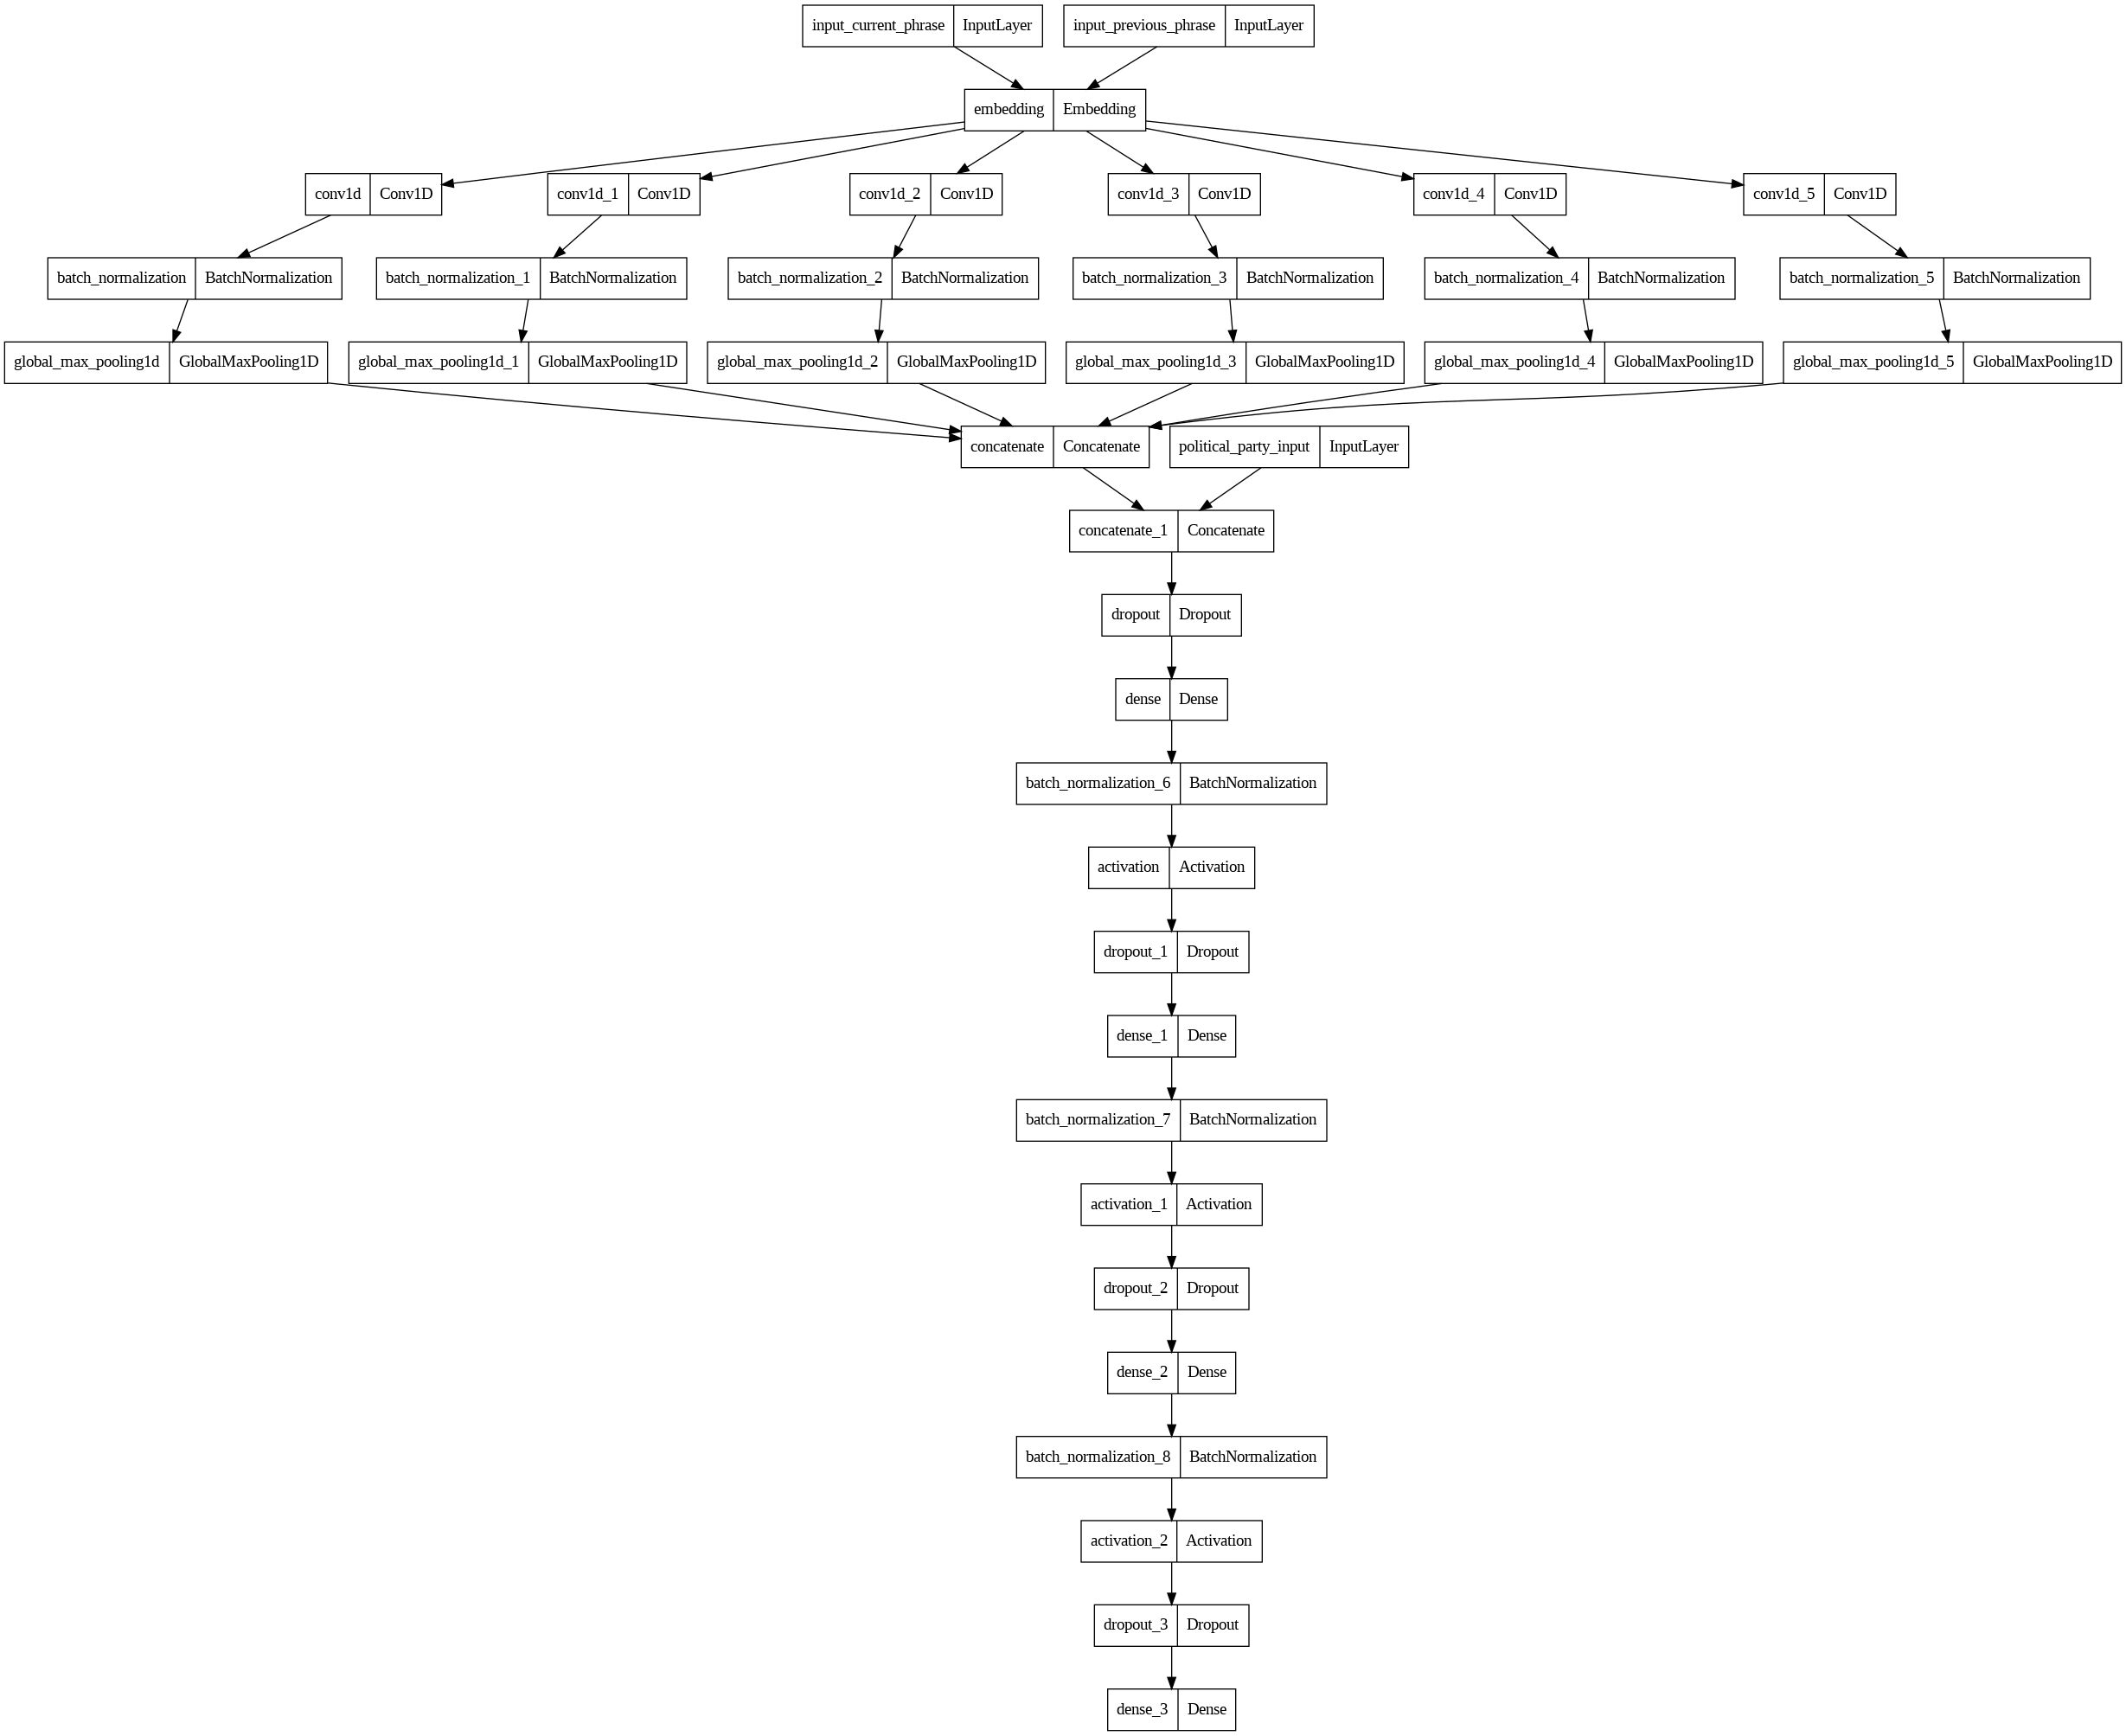

In [63]:
tf.keras.utils.plot_model(model)

In [44]:
domain_norm = data['domain'].astype(int) - 1
subdomain_norm = data['subdomain'].astype(int) - 1

In [45]:
# Preparing inputs
X_prev = np.stack(data['prev_phrase'].to_numpy())
X = np.stack(data['phrase'].to_numpy())
X_party = np.stack(data['party_one_hot'].to_numpy())

In [25]:
X_prev

array([[   2,   63,  827, ...,    0,    0,    0],
       [  30,   12, 1584, ...,    0,    0,    0],
       [  30,   12,   56, ...,    0,    0,    0],
       ...,
       [ 216,    2, 6716, ...,    0,    0,    0],
       [ 391,    2, 6716, ...,    0,    0,    0],
       [   3,    2, 3141, ...,    0,    0,    0]], dtype=int32)

In [26]:
X

array([[  30,   12, 1584, ...,    0,    0,    0],
       [  30,   12,   56, ...,    0,    0,    0],
       [ 186,  401,   12, ...,    0,    0,    0],
       ...,
       [ 391,    2, 6716, ...,    0,    0,    0],
       [   3,    2, 3141, ...,    0,    0,    0],
       [ 528,    2, 6716, ...,    0,    0,    0]], dtype=int32)

In [27]:
X_party

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
X_party.shape

(84737, 54)

In [29]:
from keras.utils import to_categorical
y_domain = to_categorical(domain_norm.to_numpy())
y_subdomain = to_categorical(subdomain_norm.to_numpy())

In [30]:
y_domain

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [31]:
y_subdomain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
from sklearn.model_selection import train_test_split
# Splitting data
X_prev_train, X_prev_test, X_train, X_test, X_party_train, X_party_test, y_train, y_test = train_test_split(
    X_prev, X, X_party, y_domain,
    test_size=0.15,
    stratify=y_domain,
    random_state=42
)

In [33]:
X_prev_train.shape

(72026, 60)

In [34]:
X_train.shape

(72026, 60)

In [35]:
X_party_train.shape

(72026, 54)

In [36]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [64]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [65]:
history = model.fit((X_prev_train, X_train, X_party_train), y_train, epochs=60, validation_split=0.15, callbacks=[early_stopping_cb])

Epoch 1/60
1914/1914 [==============================] - 55s 24ms/step - loss: 1.7674 - accuracy: 0.0000e+00 - f1_score: 0.1260 - auc: 0.7061 - val_loss: 1.5193 - val_accuracy: 0.0000e+00 - val_f1_score: 0.1053 - val_auc: 0.7965
Epoch 2/60
1914/1914 [==============================] - 35s 18ms/step - loss: 1.5250 - accuracy: 0.0000e+00 - f1_score: 0.2026 - auc: 0.7908 - val_loss: 1.3442 - val_accuracy: 0.0000e+00 - val_f1_score: 0.3074 - val_auc: 0.8410
Epoch 3/60
1914/1914 [==============================] - 35s 18ms/step - loss: 1.4489 - accuracy: 0.0000e+00 - f1_score: 0.2489 - auc: 0.8127 - val_loss: 1.2946 - val_accuracy: 0.0000e+00 - val_f1_score: 0.3112 - val_auc: 0.8562
Epoch 4/60
1914/1914 [==============================] - 35s 18ms/step - loss: 1.4161 - accuracy: 0.0000e+00 - f1_score: 0.2621 - auc: 0.8221 - val_loss: 1.2629 - val_accuracy: 0.0000e+00 - val_f1_score: 0.3608 - val_auc: 0.8657
Epoch 5/60
1914/1914 [==============================] - 34s 18ms/step - loss: 1.3922 - a

#### Test 3 (Test 2 + Untrainable Embedding). Results

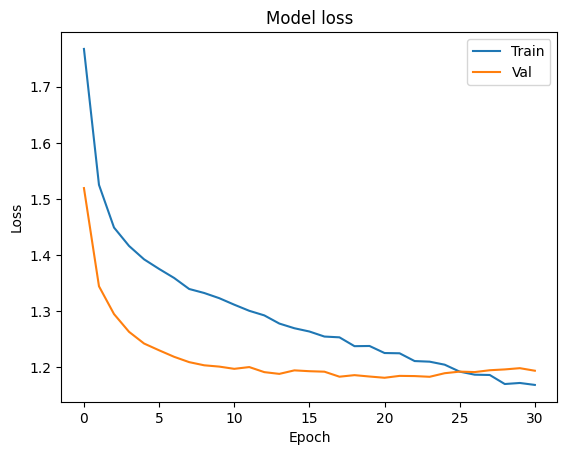

In [66]:
#Visualize the models loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

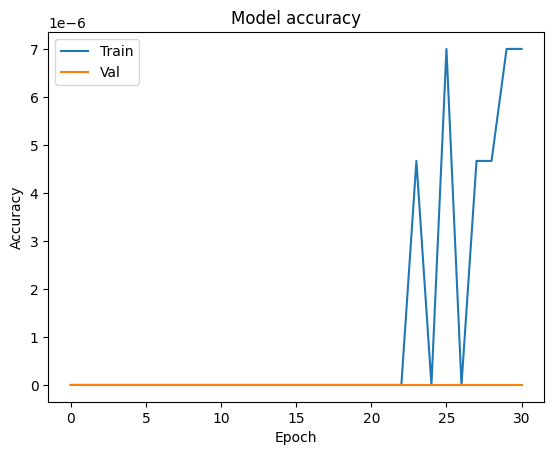

In [67]:
# Visualize the models accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

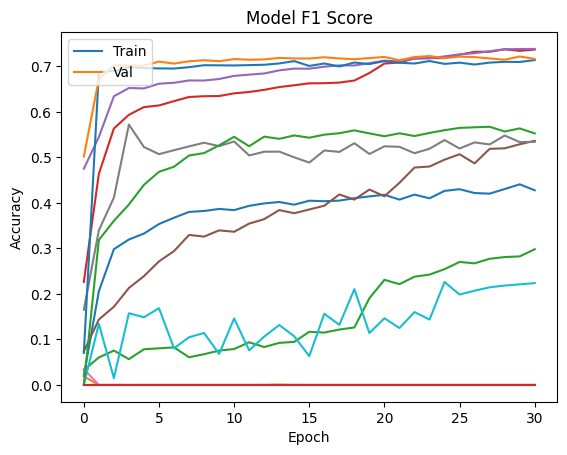

In [68]:
# Visualize the models accuracy
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

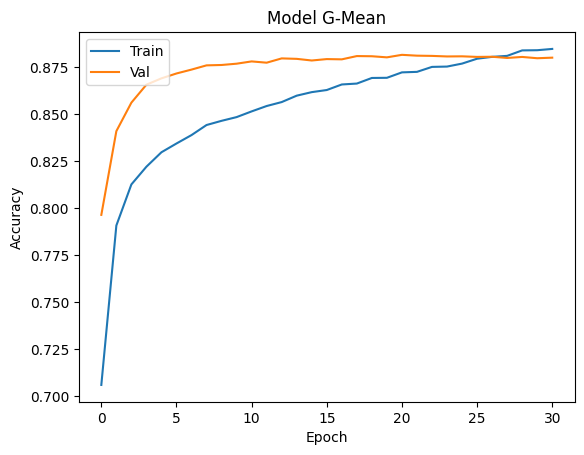

In [69]:
# Visualize the models accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model G-Mean')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### Test 2 (Deeper Dense Layer, Smaller Number of Neurons, Higher Dropout, Batch Normalization). Results

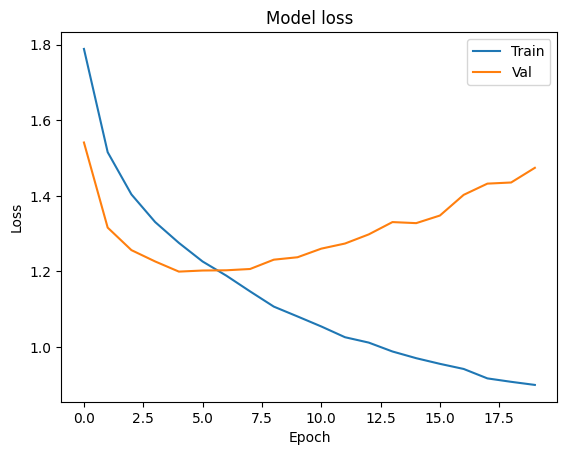

In [56]:
#Visualize the models loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

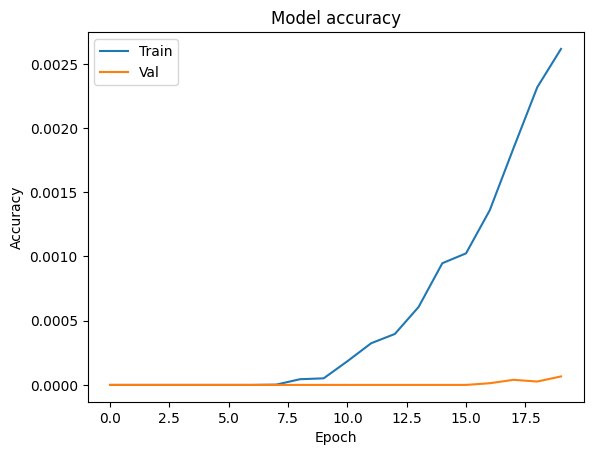

In [58]:
# Visualize the models accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

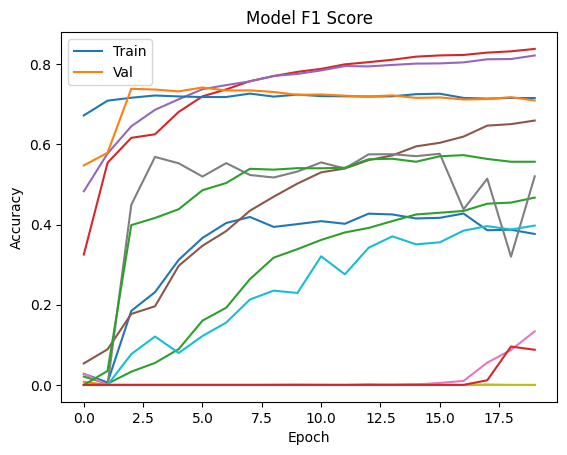

In [59]:
# Visualize the models accuracy
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

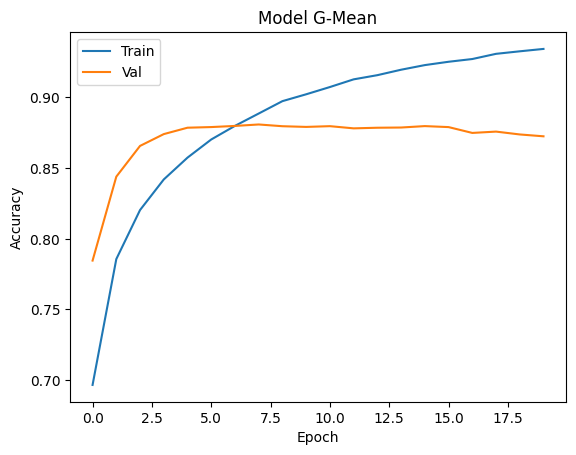

In [60]:
# Visualize the models accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model G-Mean')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### Test 1 (Deeper Dense Layer, Lower Dropout, Batch Normalization). Results

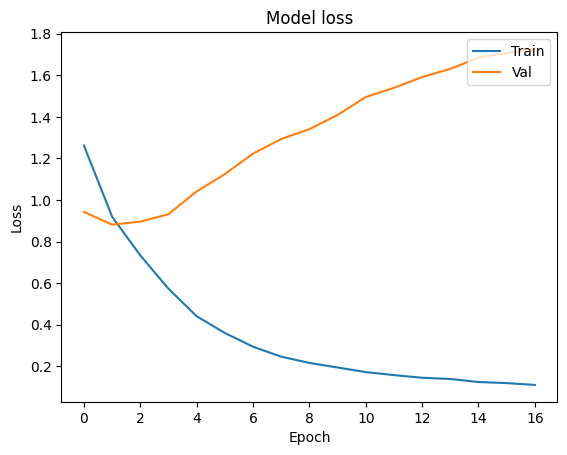

In [47]:
#Visualize the models loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

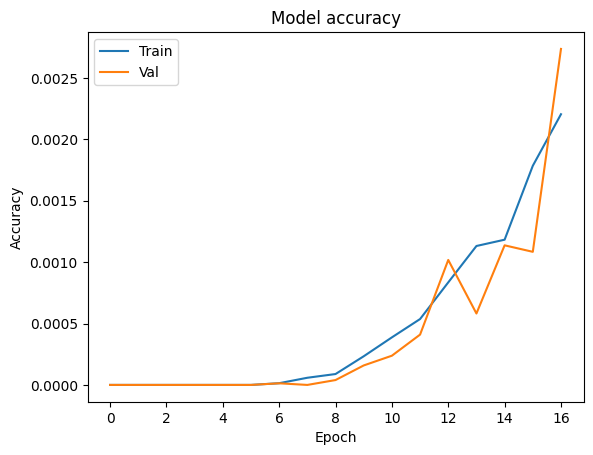

In [48]:
# Visualize the models accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

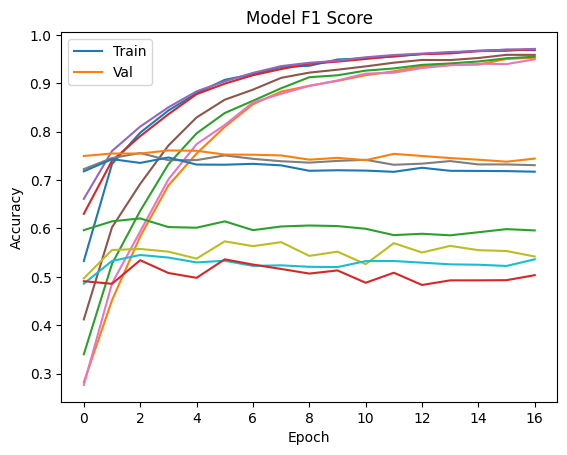

In [53]:
# Visualize the models accuracy
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

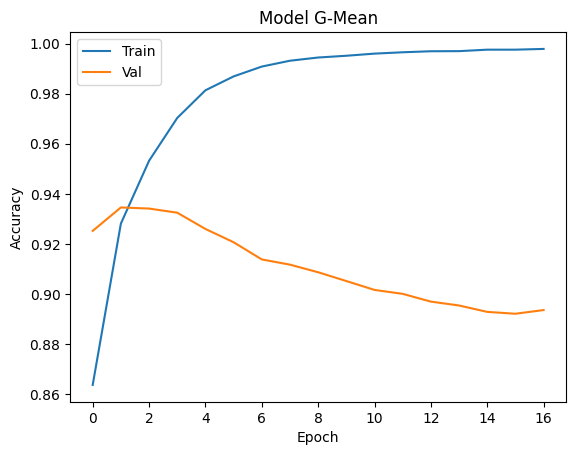

In [54]:
# Visualize the models accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model G-Mean')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### The Original Model. Results

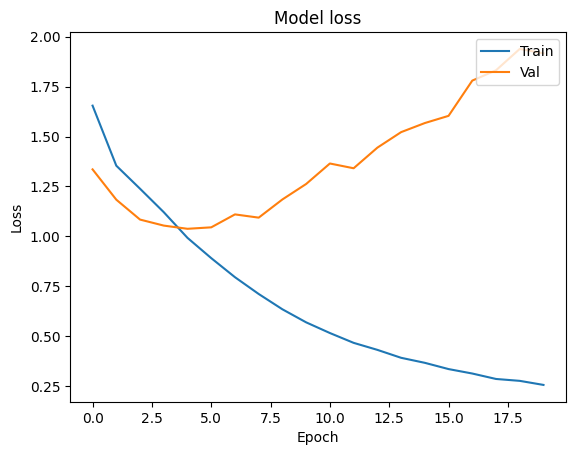

In [ ]:
#Visualize the models loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

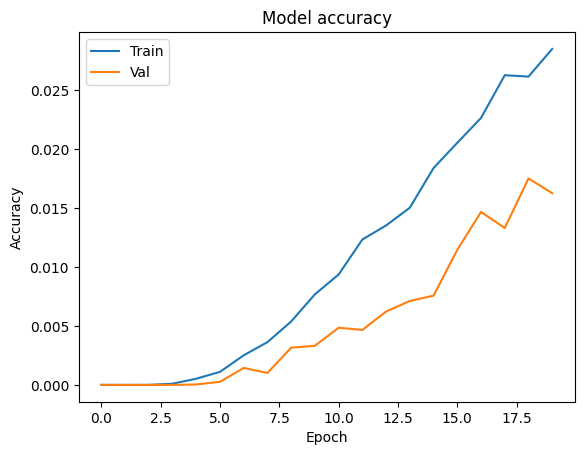

In [ ]:
# Visualize the models accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

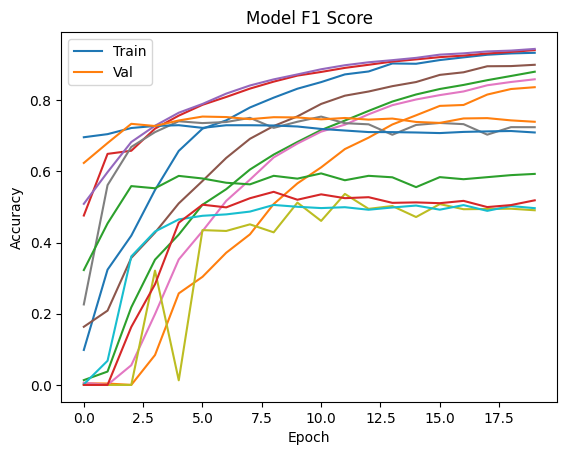

In [ ]:
# Visualize the models accuracy
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

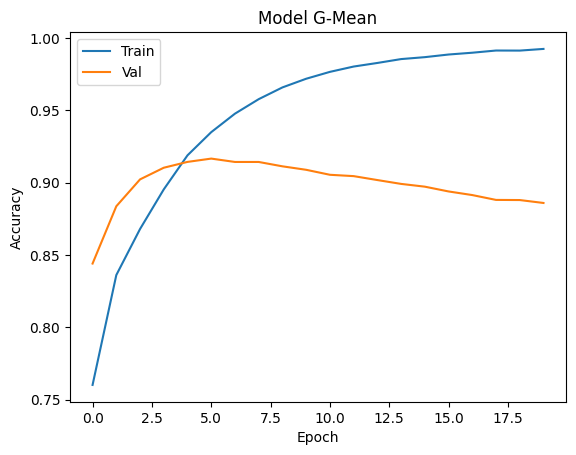

In [ ]:
# Visualize the models accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model G-Mean')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate((X_prev_test, X_test, X_party_test), y_test)

398/398 [==============================] - 2s 5ms/step - loss: 0.9998 - accuracy: 6.7433e-05 - f1_score: 0.5411 - auc: 0.9184


[0.9998435974121094,
 6.743316043866798e-05,
 array([0.7530505 , 0.0037594 , 0.48817462, 0.73497057, 0.7493576 ,
        0.59849626, 0.46023858], dtype=float32),
 0.9183821678161621]

### Article Results vs Current Results for a given architecture:

*   Acc: 69.02%/0.0067433%
*   F1:65.32/54.11
*   G-M: 78.41/91.84

### Conclusions
Current re-creation of the model is functional but requires a major performance check in order to achieve the results mentioned in the study.